## **Data Pre-processing**

---



---



**Import Packages**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
#fetch data

df = pd.read_csv("/content/drive/My Drive/dataset/steam game/train.csv")


In [3]:
df

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


There is very less correlation between year and user_suggestion. Thinking, If a game is great/trash it doesn't depend on the year. Review id of a user also doesn't affect the suggestion.Let's drop the unwanted columns from the dataset.

---



In [0]:
df.drop(['review_id'], axis=1, inplace=True)

In [5]:
df['year'].corr(df['user_suggestion'])

-0.12004374888886256

In [0]:
df.drop(['year'], axis=1, inplace=True)

User suggestions

In [7]:
df['user_suggestion'].value_counts()

1    9968
0    7526
Name: user_suggestion, dtype: int64

This looks almost like a balanced dataset.

**Sample reviews**

---



How does **user_suggestion == 0** look?

That is how does a **negative user_review** look like?

In [8]:
df[df['user_suggestion'] == 0]['user_review'].iloc[1]

'Has a few nice elements but overall quite boring and repetitive.+++ music and sounds++ free+ things popping up at the start, then I just got used to it+ some visuals+ humor--- repetitive-- going through 60+ boring rooms and then getting killed out of nowhere... waste of time- story- movement, can\'t "slide" on edges, blocks your movement- monsters jumping out of nowhere and killing youOverall 5/10.'

We can see that some seperate words are appended as one :

Example : youOverall --> "you Overall"

---
Next,
How does **user_suggestion == 1** look?

That is how does a **positive user_review** look like?

---



In [9]:
df[df['user_suggestion'] == 1]['user_review'].iloc[1]

"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet."

**Non-English Reviews?**

Are there any reviews which are not in english. Let's see a sample non-english review.

---



In [10]:
df['user_review'].iloc[331]

'ROOM 1 : AHHHH WHAT A CUTE GAME ROOM 60 : Exorcizamus te, omnis immundus spiritus, omnis satanica potestas, omnis incursio infernalis adversarii, omnis legio, omnis congregatio et secta diabolica. Ergo, omnis legio diabolica, adiuramus te...cessa decipere humanas creaturas, eisque æternæ perditionìs venenum propinare...Vade, satana, inventor et magister omnis fallaciæ, hostis humanæ salutis...Humiliare sub potenti manu Dei; contremisce et effuge, invocato a nobis sancto et terribili nomine...quem inferi tremunt...Ab insidiis diaboli, libera nos, Domine. Ut Ecclesiam tuam secura tibi facias libertate servire, te rogamus, audi nos.'

Let's get all the reviews list which are not english and remove them.

In [11]:
!pip install langdetect
from langdetect import detect
from tqdm import tqdm_notebook

     |████████████████████████████████| 983kB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=15fd61f42bde33bf0bb23166f9a3fdc5ea38b9e43c2a449bb9fffe6e754aaf1f
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [14]:
# Sample usage : 
df['user_review'].iloc[1][: 20], detect(df['user_review'].iloc[1])

('Best game, more bett', 'en')

**'en'** is the language code for english. Any language codes different than 'en' would represent that is non-english.

In [0]:
def get_language(X):
    try:
        return detect(X)
    except:
        return "Error"

In [0]:
df['user_review_language'] = df['user_review'].apply(lambda x: get_language(x))

In [17]:
print("Original Shape : {}".format(df.shape))

new_lang_df = df[df['user_review_language'] != 'en'].copy()
df = df[df['user_review_language'] == 'en'].copy()

print("New Shape : {}".format(df.shape))

Original Shape : (17494, 4)
New Shape : (17277, 4)


Almost removed 214 records.

**Cleaning Text**

---




1. Removing "Early Access Review" : This phrase is added in the starting for reviews which are given by the users who get an early access pass.
2. Splitting combined numbers and text : "12AB" --> "12 AB"
3. Handling CamelCase : "youOn" --> "you On"
4. Removing extra whitespaces in between words, sentences, left & right trailing.
5. Removing waste symbols.
6. Removing stop words(Certain words are used to formulate sentences but do not add any semantic meaning to the text.These are known as stop-words in NLP.)



Import necessary libraries and define functions to perform these operations.

In [21]:
import re
from re import finditer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_EAR(X):
    """
    Removing 'Early Access Review'
    """
    X = X.replace("Early Access Review", "")
    
    return X

def split_number_and_text(X):
    x = re.split('(\d+)', X)
    x = " ".join(x)
    x = x.strip()
    
    return x


def handle_camelcase(X):
    matches = finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', X)
    return " ".join([m.group(0) for m in matches])

def handling_whitespaces(X):
    X = " ".join(X.split())
    X = X.strip()
    
    return X

waste_symbols = "人̳⣟⣦̪⠓▒͎¸⠟⣅>⡾ ⠻⣀⣛„ͭ⣮⡻⠦⡀͐‘̨⣆̤⣿<／丶⣞͇⣵͞⠹ͩ⢒̯⢸⣤̗̫ͯ͆̔͠⠛⢻⠏-́☐̺͛̋⠸⣥⠄̷＼͟·⌒͗⠁́｀⢹\\⢄͈̌ͨ⢤彡~¯/⠶⠲ˆ⡥̮̻͔☉⣻̣ゝ⡞̧͙̿̒̊̑ノ⠭ͤ_⠐⣇҉̚–⡄´̓█▄☑⣧̴͖̍｜⣷̭͘͝｡⠴̜̄ʖ¨̵̏͢⢂͋;͒:⢉つ̾＿̈⣴⣌ͫ⢛⡹⣈へ⢯,̅⣭̩̬̕⡈ム͡⣼ͦ)̛͜ヽ̝̥⣠⢟̶⠤̡͉⠘̹̈́⡴̠⢀）⠇⣾͊⢰̞ͮ̇`⠑⡿\u3000⠃⣸⠾͍̆ͅ￣⢚̓⠂⡵─⢬ー⠿(⠆⠉̦*͕ﾉ⣹⡟⣬⠙▓⡐7͏̟̲⢿⢦（̰♥̸̢⣙͓̂▀くﾌ⠀.⠰⡒°̖̎､⣒⣰̼⢅⣁⠒͑⢾⡂͌̀ͧ…̃▐ﾚ、丿⢌|̱⢴⡠⣩▌⣉͚ͪ'⢆⢠⡇⡛⣏⡶⣜⣄⡸⠈̘ͣ⣽̉̽̐ͥ⡏ͬ⣗⣶░⠋⠔̙͂^"

def remove_waste_symbols(X):
    for item in waste_symbols:
        X = X.replace(item, " ")
        
    return X

stops = list(set(stopwords.words("english")))
def text_to_words(X):
  letters = re.sub("[^a-zA-Z]"," ",X)
  word = letters.lower().split()
  meaningful_words = [w for w in word if w not in stops]
  return " ".join(meaningful_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def clean_review(X):
    X = remove_EAR(X)
    X = remove_waste_symbols(X)
    X = handle_camelcase(X)
    X = split_number_and_text(X)
    X = handling_whitespaces(X)
    X = text_to_words(X)
    return X

In [0]:
# clean the data by calling the clean_review function
# store the cleaned data in a new column 

df['user_review_clean'] = df['user_review'].apply(lambda x: clean_review(x))

In [0]:
#reset the index

df.reset_index(drop=True, inplace=True)

The new Dataframe looks like this after cleaning:-

In [25]:
df

,title,user_review,user_suggestion,user_review_language,user_review_clean
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,en,scared hearing creepy voices pause moment writ...
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,en,best game better sam pepper tube account need ...
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1,en,littly iffy controls know play easy master mad...
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,en,great game fun colorful side note though getti...
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,en,many games cute tag right next horror tag stea...
...,...,...,...,...,...
17272,EverQuest II,Arguably the single greatest mmorp that exists...,1,en,arguably single greatest mmorp exists today fr...
17273,EverQuest II,"An older game, to be sure, but has its own cha...",1,en,older game sure charm holds special place hear...
17274,EverQuest II,When I frist started playing Everquest 2 it wa...,1,en,frist started playing everquest amazing still ...
17275,EverQuest II,cool game. THe only thing that REALLY PISSES M...,1,en,cool game thing really pisses ridable transpor...


In [0]:
# upload the cleaned dataset to drive so that it doesn't have to be cleaned again

df.to_csv('SteamGamesClean.csv')
!cp SteamGamesClean.csv "/content/drive/My Drive/dataset"

# **Word Embeddings**

---



---



Word embedding is one of the most popular representation of document vocabulary.They are a type of word representation that allows words with similar meaning to have a similar representation.

Neural Networks are designed to learn from numerical data.

Word Embedding is really all about improving the ability of networks to learn from text data. By representing that data as lower dimensional vectors. These vectors are called Embedding.

Click on link to read more about WordEmbedding

[What the heck is Word Embedding?](https://towardsdatascience.com/what-the-heck-is-word-embedding-b30f67f01c81)

**Embedding Layer**

An embedding layer, for lack of a better name, is a word embedding technique that is learned jointly with a neural network model on a specific natural language processing task, such as language modeling or document classification.


In [0]:
# import the necessary libraries to perform vectorization and create the model

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras  
from sklearn.model_selection import train_test_split

In [0]:
#check target

target = df['user_suggestion'].values

In [29]:
# check cleaned user reviews

df['user_review_clean']

0        scared hearing creepy voices pause moment writ...
1        best game better sam pepper tube account need ...
2        littly iffy controls know play easy master mad...
3        great game fun colorful side note though getti...
4        many games cute tag right next horror tag stea...
                               ...                        
17272    arguably single greatest mmorp exists today fr...
17273    older game sure charm holds special place hear...
17274    frist started playing everquest amazing still ...
17275    cool game thing really pisses ridable transpor...
17276    game since little kid always since still remem...
Name: user_review_clean, Length: 17277, dtype: object

In [0]:
# Tokenize each sentence 

review_tokens = [row.split() for row in df['user_review_clean']]

In [0]:
# create vocabulary out of all the token words

vocab = []
for token in review_tokens:
  vocab.extend(token)

In [32]:
# create a vocabulary - making sure each word appears only once

vocabulary = list(set(vocab))

# get the count of unique words in our vocabulary

len(vocabulary)

41801

In [33]:
# check vocabulary

vocabulary

['expertly',
 'cabin',
 'maters',
 'pigsy',
 'spawncampeed',
 'torelable',
 'birth',
 'happy',
 'afc',
 'peacefully',
 'missunderstand',
 'enver',
 'deviously',
 'prototypes',
 'swears',
 'neede',
 'saty',
 'kudo',
 'testicular',
 'treure',
 'legendaires',
 'seasoning',
 'franceman',
 'edged',
 'rats',
 'operas',
 'coma',
 'kplanes',
 'polar',
 'blade',
 'automating',
 'partisipate',
 'aiplanes',
 'rss',
 'lake',
 'sobek',
 'beffore',
 'shouls',
 'speeed',
 'relitivly',
 'iamcvh',
 'diffcult',
 'steel',
 'insurgency',
 'borderline',
 'quirk',
 'lloved',
 'cities',
 'truley',
 'tains',
 'spent',
 'kant',
 'left',
 'upgrade',
 'shoveling',
 'ugh',
 'prophecy',
 'teenager',
 'ejoys',
 'funt',
 'nono',
 'defuses',
 'doom',
 'crew',
 'slithery',
 'replacement',
 'uless',
 'iti',
 'voice',
 'asyou',
 'hostility',
 'drunkenly',
 'compertive',
 'differentiated',
 'coudn',
 'environmentalists',
 'miscellaneous',
 'stirred',
 'inconvinent',
 'fuller',
 'azz',
 'rockin',
 'seamlessly',
 'livery',

**Word Cloud of words in the vocabulary**

Word cloud is an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.So, the more often a specific words appears in your text, the bigger and bolder it appears in your word cloud.

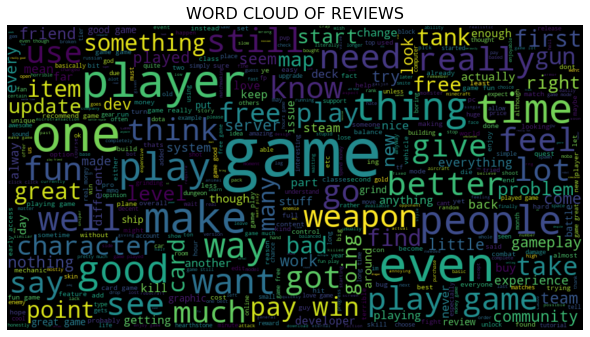

In [34]:
from wordcloud import WordCloud
wordcloud_text = " ".join(vocab)

wordcloud =  WordCloud(width=850, height=450, background_color="black", max_words=500, max_font_size=100, 
                       contour_width=2, contour_color='black').generate(wordcloud_text)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.title("WORD CLOUD OF REVIEWS", fontsize=16)
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [35]:
vectorizer = LabelEncoder()
vectorizer.fit(vocabulary)

LabelEncoder()

In [36]:
# Create token vector using Label Encoder fit on entire vocabulary

token_vector = []

# declare max_words to keep count of the longest sentence vectorized
# we need this to pad every other vector to same length as longest vector

max_tokens = 0
for row in review_tokens:
  encoded = vectorizer.transform(row).tolist()
  size = len(encoded)
  if size > max_tokens:
    max_tokens = size
  token_vector.append(encoded)

KeyboardInterrupt: ignored

In [0]:
# Check longest vector length

max_tokens

In [0]:
# Pad every vector in token vector corpus to be as long as longest vector

padded = []

for row in token_vector:
  r = np.pad(row, (0, max_tokens-len(row)), 'constant')
  padded.append(r) 

In [0]:
# Convert it into numpy array, we'll call this the examples vector
# as it contains all the example to be trained on

ex_vector = np.array(padded)
ex_vector

In [0]:
# Split the data into test & train dataset

xtrain, xtest, ytrain, ytest = train_test_split(ex_vector,target, test_size=0.2)

We need to load and convert the numpy array into a **Tensor** and then transform that into a **BatchDataset TF Object** to load into the Embedding Layer in our Keras Model

The model will not accept if we dont do the next two cells.

---



In [0]:
# Create a tensor out of numpy arrays

train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest))

In [0]:
# shuffle the data and create batches out of it

BATCH_SIZE = 200
SHUFFLE_BUFFER_SIZE = 300

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
type(train_dataset)

## **Creating our model**

In [0]:

# Define the embedding dimensions // features around which the model will learn correlation based on.

embedding_dim=25

# defining the sequential model with an Embedding layer
# Add a Global Average Pooling 1D layer to flatten the matrix into vector

model = keras.models.Sequential([
  keras.layers.Embedding(len(vocabulary), embedding_dim),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(15, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
# Train the model and benchmark against Test Data as it's validation data

epochs=10
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=2)

In [0]:
epoch = model.history.epoch
history = model.history.history

In [0]:
# Plot Accuracy


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch, history['loss'], 'b', epoch, history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(epoch, history['accuracy'], 'b', epoch, history['val_accuracy'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

**Result:-**

Train accuracy: 83.85%

Validation accuracy: 84.23%

In the next notebook, we will perform simpler vectorization techniques like CountVectorizer and TfidfVectorizer